In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [2]:
data = h5py.File('dataset.hdf5', 'r')
data.keys()

<KeysViewHDF5 ['trnCsm', 'trnMask', 'trnOrg', 'tstCsm', 'tstMask', 'tstOrg']>

In [3]:
trnOrg = data['trnOrg']
trnMask = data['trnMask']
tstOrg = data['tstOrg']
tstMask = data['tstMask']
print(np.array(data['trnOrg']).shape)

(360, 256, 232)


In [4]:
# load ground truth data
Y_train = np.array(trnOrg)
Y_test = np.array(tstOrg)

# load mask data
mask_trn = np.array(trnMask)
mask_tst = np.array(tstMask)

# fourier transform ground truth data
Y_train_fft = np.fft.fft2(Y_train)
Y_test_fft = np.fft.fft2(Y_test)

# sample ground truth data using masks
Y_train_sampled = np.multiply(Y_train_fft, mask_trn)
Y_test_sampled = np.multiply(Y_test_fft, mask_tst)

Y_train.shape

(360, 256, 232)

In [5]:
# add noise
sigma = 0.1

noisy_trn = Y_train_sampled + sigma * np.random.randn(*Y_train_sampled.shape)
noisy_tst = Y_test_sampled + sigma * np.random.randn(*Y_test_sampled.shape)

In [6]:
## complex value interleaving
def encode_complex_to_real(images):
    num_images = images.shape[0]
    encoded_images = np.zeros((num_images, images.shape[1], images.shape[2], 2), dtype=np.uint8)

    for i in range(num_images):
        magnitude = np.abs(images[i])
        phase = np.angle(images[i])

        # Fill in the encoded image with magnitude and phase channels
        encoded_images[i, :, :, 0] = magnitude
        encoded_images[i, :, :, 1] = phase

    return encoded_images

def decode_real_to_complex(encoded_images):
    num_images = encoded_images.shape[0]
    decoded_images = np.zeros((num_images, encoded_images.shape[2], encoded_images.shape[3]), dtype=np.complex64)

    for i in range(num_images):
        magnitude = encoded_images[i, 0, :, :]
        phase = encoded_images[i, 1, :, :]

        # Fill in the encoded image with magnitude and phase channels
        decoded_images[i] = magnitude * np.exp(1j*phase)

    return decoded_images

X_train = np.fft.ifft2(noisy_trn)
X_test = np.fft.ifft2(noisy_tst)

X_train_re = encode_complex_to_real(X_train)
X_test_re = encode_complex_to_real(X_test)
Y_train_re = encode_complex_to_real(Y_train)
Y_test_re = encode_complex_to_real(Y_test)

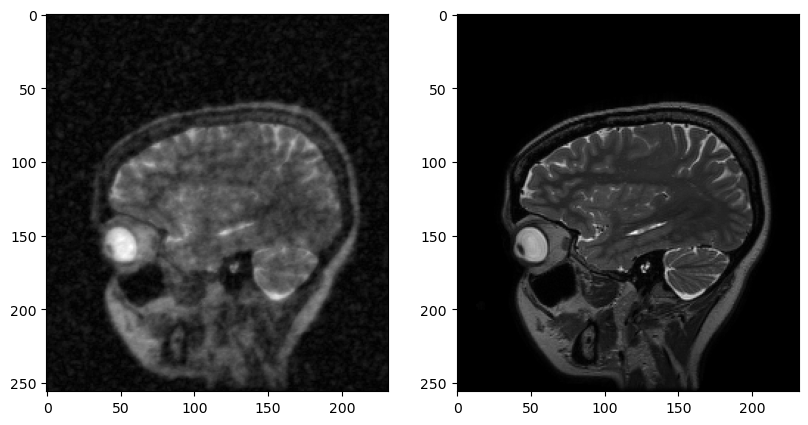

In [7]:
# create figure with subplots
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(np.abs(X_train[50]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(Y_train[50]), cmap='gray')

In [8]:
X_train_re.shape, X_test_re.shape, Y_train_re.shape, Y_test_re.shape

((360, 256, 232, 2),
 (164, 256, 232, 2),
 (360, 256, 232, 2),
 (164, 256, 232, 2))

In [9]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((360, 256, 232), (164, 256, 232), (360, 256, 232), (164, 256, 232))

In [10]:
X_train_re.dtype, X_test_re.dtype, Y_train_re.dtype, Y_test_re.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, testing=False):
        super(UNet, self).__init__()

        # test mode: default false
        self.testing = testing
        
        # Downsample path
        self.down1 = self.double_conv(in_channels, 64)
        self.down2 = self.double_conv(64, 128)
        self.down3 = self.double_conv(128, 256)
        self.down4 = self.double_conv(256,512)

        
        # Upsample path
        self.up1 = self.up_conv(512, 256)
        self.up2 = self.up_conv(256,128)
        self.up3 = self.up_conv(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        #self.final = self.compress(out_channels, out_channels)
        
        
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels) if not self.testing else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels) if not self.testing else nn.Identity(),
            nn.ReLU(inplace=True)
        )
        
    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(out_channels) if not self.testing else nn.Identity(),
            nn.ReLU(inplace=True)
        )
    
    """ def compress(self, in_channels, out_channels):
        return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(4,1), padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True)
    ) """
        
    def forward(self, x):
        # Downsample path
        #print(f'x: {x.shape}')
        x1 = self.down1(x)
        #print(f'x1: {x1.shape}')
        x2 = self.down2(x1)
        #print(f'x2: {x2.shape}')
        x3 = self.down3(x2)
        #print(f'x3: {x3.shape}')
        x4 = self.down4(x3)
        #print(f'x4: {x4.shape}')

        # Upsample path
        x = self.up1(x4)
        #print(f'x: {x.shape}')
        x = self.up2(x)
        #print(f'x: {x.shape}')
        x = self.up3(x)
        #print(f'x: {x.shape}')

        # Output layer
        x = self.out(x)
        #print(f'x: {x.shape}')
        ##x = self.final(x)
        ##print(f'x: {x.shape}')
        return x

In [12]:
X_train_re.shape

(360, 256, 232, 2)

In [15]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        target = self.Y[idx]

        if self.transform:
            image = self.transform(image).float().squeeze()
            #print(f'image: {image.shape}')
            target = self.transform(target).float().squeeze()

        return image, target

In [16]:
X_train_n = np.reshape(np.abs(X_train),(360, 256, 232, 1))
Y_train_n = np.reshape(np.abs(Y_train),(360, 256, 232, 1))

# normalize data
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def denormalize(data, original):
    return data * (np.max(original) - np.min(original)) + np.min(original)

In [17]:

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Assuming you have X_train, y_train as your training data

# Define dataset and data loaders
print(X_train_n[50:68].shape)
train_dataset = MRIDataset(X_train_n[50:68], Y_train_n[50:68] , transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=True)

# Initialize the U-Net model
model = UNet(in_channels=1, out_channels=1)  # Modify the in_channels and out_channels based on your data

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        
        print(images.shape)
        images = images.view(18,1,256,232)
        targets = targets.view(18,1,256,232)
        ##images = images[:,0,:,:].unsqueeze(1)
        ##targets = targets[:,0,:,:].unsqueeze(1)
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print mini-batch progress
        if (batch_idx + 1) % 1 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training finished!")

(18, 256, 232, 1)
torch.Size([18, 256, 232])
Epoch 1/30, Batch 1/1, Loss: 0.1339
Epoch 1/30, Loss: 0.1339
torch.Size([18, 256, 232])
Epoch 2/30, Batch 1/1, Loss: 0.3250
Epoch 2/30, Loss: 0.3250
torch.Size([18, 256, 232])
Epoch 3/30, Batch 1/1, Loss: 0.0628
Epoch 3/30, Loss: 0.0628
torch.Size([18, 256, 232])
Epoch 4/30, Batch 1/1, Loss: 0.0455
Epoch 4/30, Loss: 0.0455
torch.Size([18, 256, 232])
Epoch 5/30, Batch 1/1, Loss: 0.0378
Epoch 5/30, Loss: 0.0378
torch.Size([18, 256, 232])
Epoch 6/30, Batch 1/1, Loss: 0.0247
Epoch 6/30, Loss: 0.0247
torch.Size([18, 256, 232])
Epoch 7/30, Batch 1/1, Loss: 0.0194
Epoch 7/30, Loss: 0.0194
torch.Size([18, 256, 232])
Epoch 8/30, Batch 1/1, Loss: 0.0168
Epoch 8/30, Loss: 0.0168
torch.Size([18, 256, 232])
Epoch 9/30, Batch 1/1, Loss: 0.0136
Epoch 9/30, Loss: 0.0136
torch.Size([18, 256, 232])
Epoch 10/30, Batch 1/1, Loss: 0.0109
Epoch 10/30, Loss: 0.0109
torch.Size([18, 256, 232])
Epoch 11/30, Batch 1/1, Loss: 0.0094
Epoch 11/30, Loss: 0.0094
torch.Size

KeyboardInterrupt: 

torch.Size([1, 256, 232])


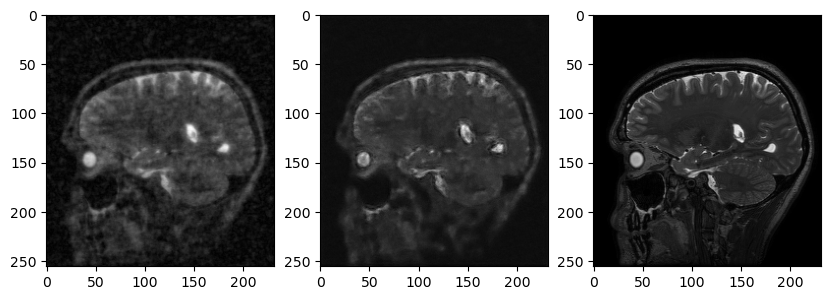

In [18]:
# Create the train dataset
# create the test loader


# set model to testing mode
model.testing = True



# create figure with subplots
plt.figure(figsize=(10,30))
plt.subplot(1,3,1)
# input test image
plt.imshow(np.abs(X_train[60]), cmap='gray')
plt.subplot(1,3,2)
# output test image
print(train_dataset[10][0].unsqueeze(0).shape)
plt.imshow(model(train_dataset[10][0].unsqueeze(0).view(1,1,256,232)).detach().numpy().squeeze(), cmap='gray')
plt.subplot(1,3,3)
# ground truth test image
plt.imshow(np.abs(Y_train[60,:,:]), cmap='gray')